# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [5]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.7698500479884e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [6]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0908210113205496e-10
dw error:  2.273805557790167e-10
db error:  7.736978834487815e-12


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [8]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [14]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

[[1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]]
Testing relu_backward function:
dx error:  1.0


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [15]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  1.0
dw error:  1.0
db error:  1.0


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [16]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [11]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
3.47022435559539
26.594842695238583
Running numeric gradient check with reg =  0.0
3.47022435559539
3.47022435559539
3.4702240577129877
3.470224653477809
3.4702240577129877
3.4702246534778087
3.470224057712988
3.47022465347781
3.470224057712987
3.4702246534778083
3.4702240577129886
3.470224653477809
3.4702240577129877
3.470224653477809
3.470224057712987
3.470224653477809
3.4702240577129886
3.4702246534778087
3.4702240577129886
3.47022465347781
3.4702240577129864
3.470224653477809
3.4702240577129877
3.4702246534778083
3.4702240577129877
3.470224653477809
3.4702240577129886
3.47022465347781
3.4702240577129877
3.4702246534778083
3.470224057712988
3.4702246534778087
3.4702240577129864
3.4702246534778087
3.4702240577129877
3.470224653477809
3.4702240577129864
3.470224653477809
3.4702240577129877
3.47022465347781
3.4702240577129877
3.470224653477809
3.4702240577129877
3.4702246534778083


3.4702202749682844
3.4702284367004093
3.4702494944308033
3.4701992173932834
3.470204744491165
3.4702439667188543
3.470211951953184
3.4702367592757604
3.470225919896262
3.470222791369867
3.4702274733729683
3.470221237964631
3.4702305906335873
3.470218120833973
3.470220266543782
3.470228445126487
3.470249543112402
3.470199168713766
3.470204758895312
3.4702439523148016
3.470211871738213
3.470236839490903
3.470225923921209
3.470222787345236
3.4702274808864604
3.470221230451706
3.4702306046517726
3.470218106816772
3.470220258119283
3.4702284535525685
3.470249591794006
3.4701991200342555
3.4702047732994594
3.470243937910748
3.470211791523241
3.470236919706048
3.4702259279461565
3.470222783320606
3.470227488399954
3.470221222938783
3.470230618669961
3.4702180927995747
3.4702202496947883
3.470228461978655
3.470249640475616
3.47019907135475
3.4702047877036066
3.470243923506695
3.47021171130827
3.4702369999211933
3.4702259319711053
3.4702227792959763
3.47022749591345
3.470221215425862
3.47023063

3.4702209299360476
3.4702311653815165
3.4702175461310714
3.470219921143117
3.4702287905996223
3.470251539063177
3.4701971728588146
3.470205349465555
3.470243361748834
3.4702085829247893
3.470240128312232
3.470226088944797
3.4702226223361285
3.470227788941035
3.4702209224231892
3.470231179399819
3.470217532113987
3.4702199127188074
3.4702287990258935
3.470251587745031
3.470197124179554
3.4702053638697117
3.4702433473447925
3.4702085027098377
3.4702402085273967
3.4702260929697815
3.470222618311535
3.4702277964545956
3.4702209149103322
3.470231193418124
3.4702175180969057
3.4702199042945026
3.4702288074521697
3.470251636426891
3.4701970755002978
3.4702053782738704
3.47024333294075
3.4702084224948866
3.470240288742561
3.4702260969947667
3.470222614286943
3.4702278039681573
3.470220907397478
3.4702312074364308
3.4702175040798267
3.4702198958702026
3.47022881587845
3.470251685108758
3.4701970268210496
3.4702053926780287
3.4702433185367076
3.4702083422799372
3.4702403689577266
3.4702261010197

19.657455992792805
19.657458422080904
19.657455964680352
19.657458450193356
19.657455936567903
19.657458478305806
19.657455908455454
19.657458506418255
19.657455880343004
19.657458534530704
19.657455852230555
19.657458562643153
19.657455824118102
19.657458590755606
19.657455796005653
19.657458618868056
19.657455767893207
19.657458646980505
19.657455739780758
19.657458675092954
19.657455711668305
19.657458703205403
19.657455683555852
19.657458731317856
19.657455655443407
19.657458759430305
19.657455627330958
19.657458787542755
19.65745559921851
19.657458815655204
19.657455571106055
19.657458843767653
19.657455542993606
19.657458871880106
19.657455514881157
19.65745889999255
19.657455486768704
19.657458928105
19.65745545865626
19.65745895621745
19.657455430543806
19.657458984329903
19.657455402431356
19.657459012442352
19.657455374318904
19.6574590405548
19.657455346206454
19.65745906866725
19.65745531809401
19.6574590967797
19.657455289981556
19.65745912489215
19.657455261869103
19.6574

19.657460561305882
19.657453825542827
19.657462250922222
19.657452136007635
19.657465609887947
19.657448777187927
19.657454514345368
19.65745987295627
19.65748580366859
19.657428583808567
19.65743983377714
19.657474553007038
19.657443648991148
19.657470737815085
19.657460663611666
19.657453723237424
19.65746235671658
19.657452030213964
19.657465722187034
19.65744866489002
19.657454604201835
19.657459783101707
19.657485950631212
19.657428436848466
19.657439946462095
19.65747444032219
19.65744366705699
19.657470719749444
19.657460765917442
19.65745362093202
19.657462462510928
19.657451924420297
19.65746583448612
19.657448552592122
19.657454694058302
19.657459693247155
19.657486097593836
19.657428289888376
19.657440059147053
19.657474327637345
19.65744368512284
19.657470701683803
19.657460868223225
19.65745351862662
19.65746256830528
19.657451818626626
19.657465946785212
19.65744844029422
19.657454783914773
19.657459603392603
19.657486244556466
19.657428142928286
19.65744017183201
19.6574

## Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [12]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver = Solver(model, data, lr_decay=0.95, optim_config={'learning_rate':1e-3}, verbose=False)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

2.3040598883939922
619.5441879794096
12286965.516638596
17291776.624523297
24408023.749655332
32699314.407932125
20961409.00725422
19898012.37954154
20226185.69663139
27942588.775032118
28204529.31948457
21427470.55386574
33997785.421068914
47689291.74500793
35482819.529935434
52620138.85034611
39143410.937182985
60212904.973012015
43214096.513195306
44695889.51401074
63342467.667505264
45458232.194203354
54749072.32502468
45707926.689739905
17119229.945101522
32276566.033047155
45639238.12879695
19869695.572748724
40490975.96679403
31968429.4719602
51218427.30228049
41189106.59198595
50521123.31325433
26903118.99125786
30975430.278585956
30688292.780242786
40001156.60140225
39731986.17460723
28860016.39057828
41857966.27460547
36471783.951888226
41613893.422380075
75681130.03935796
47835138.58156827
39224438.90430777
71653151.24085335
72576169.7221909
60755864.99029462
28856813.41315861
46875781.35295424
24647087.247998938
44610676.77189763
29094714.793174896
45107573.62756869
4801019

43821965.692679584
31879960.845639125
31201958.405695613
30254793.19123059
31325843.99504277
16471988.93219575
11654548.502018033
31524847.868105367
19415292.73387622
37712875.7688341
30792504.975704294
23218957.606304854
16366717.490532229
26041366.434725933
45454354.5622093
35473149.53426934
51653122.46501877
34464507.75914791
83652125.62694809
138349553.42876306
37941667.59411969
55175581.93529333
58614561.232007764
68464870.37327114
53188971.215347245
45642066.17212283
48549033.96726677
46690136.37008412
43984035.27662287
45124261.70788613
36945352.18282521
47681572.653523624
41279692.561615765
44990490.591736525
17657713.84704909
28562222.080336075
23241643.200821724
21892458.94910262
29156617.1342232
75885698.97154458
42744047.72090569
49833656.71228668
21181052.278225485
40974418.04507691
16074509.238393655
42632773.42193311
27109960.455274884
27608956.757278517
53729178.4633253
32582511.491284307
80463535.12445149
26559308.53583729
55082518.33316836
30382757.307690676
49150321.

23838702.812113147
50017383.07432435
29363090.234448582
11675259.763406038
10522415.940104587
9387835.546410605
40768328.861414514
13419356.177008647
35418430.06897246
10234470.89840626
15850108.522550609
16707582.11091494
22981082.810492266
19423946.258904595
16583698.369137838
19667971.857320298
18468182.35855424
27217228.054144878
32898204.940812662
32635713.24276041
36606217.005186126
19559119.236188587
23981727.3211524
21581456.81763587
43695521.71987858
16227777.449302953
23062898.43444766
11991824.833021333
25436188.30689378
16161222.42936778
27304228.44054363
15841330.1474991
40342546.57819855
27805099.16482101
52713681.78325313
25260213.02981287
50962450.264072694
11869265.013657546
29203306.66901393
64623513.9323823
38190724.56994393
18999350.77267613
27194373.285660863
33808648.9225921
43000113.12444619
34001532.9284857
29636691.48859124
25523608.086870734
19014703.879548427
46741198.84731552
32184795.16959788
42114857.90169061
28211927.096073847
16011276.88051097
14308417.4

21897144.794132188
14207388.624984505
21381067.007734787
7957152.172910525
9675191.738751924
13057633.021810567
14506017.902468808
24233086.727730338
33556862.30846694
8243730.599572998
25993573.662323028
18112384.44805215
33630334.51540284
28091228.905908022
20869574.890610043
46822819.890560105
46524227.78364618
12153544.83633859
7150496.8558885455
22826786.44931333
18908569.949479625
26009202.204814177
36233195.20443767
23165757.28218901
16879109.496900097
13950784.316551311
21505691.370820757
55138827.40427967
31100803.81377843
20877562.13060265
17026469.38076913
25304343.793997537
45691297.97063518
30012462.39187298
18112247.989035454
44325332.86876196
23288667.648810454
41634687.23318894
13807578.091463983
10691125.952108962
27738559.89601128
38919313.24508168
23533456.75892546
41250697.20090241
21692697.510514304
24153553.04165814
8768795.457133736
8487207.421274088
28522398.367219783
15108061.066162357
24529501.005087696
31189938.845532227
27333146.930584744
25610890.6402549
92

22831877.18337129
14056660.169333162
24879715.29261565
25904836.464681644
22150537.060000893
27136872.03988361
23028703.34996373
29806425.167697467
10257418.898098577
11112308.59347623
13782881.710265435
27459746.151582707
19619364.5361118
27388663.767934915
21877273.35639019
30120073.743474852
14551229.897995772
20368802.28341899
17540267.848674856
19760094.45000896
15700831.418844141
21126377.028537165
10406103.291476239
10473039.071914395
38767981.712492265
16480923.164530851
26307149.522116575
14737450.021014793
20136389.64592607
20546615.956937086
23774298.79153696
20733349.24834387
26899328.936093073
19926426.148739472
19989704.531633906
6971972.807582375
9881416.634660847
14611975.391480401
22053540.36256714
5481018.773899505
13127948.270240046
32310887.60259962
16789961.681804292
29135648.371464502
20721194.755145535
13643458.227250136
24905671.39205575
13877715.548477473
23694700.135211065
30262356.204878166
11829627.882960672
21064092.479829196
29789817.52341991
12524299.7641

8564713.081536347
26204195.7920422
23329316.210478283
22376479.748070717
16199283.487605326
26152016.99005724
22424838.88925631
20598783.644686744
13799219.931476695
31314359.12359211
12896704.736517703
16218407.989252374
14504016.274889454
5631993.701292318
12784753.02749003
15916916.706843171
14315479.507625066
12612381.517849179
23851393.928063676
21435924.982534893
19815470.071877025
17864903.826666385
18839304.671076745
14787832.263427207
16276546.292393176
12105191.849584782
10768523.726654008
20122935.130701087
8527027.806064416
17289361.599150956
23020878.510349654
21353828.51595817
37054256.97911255
10753796.418500287
17909064.868410226
5248176.511036543
13395605.199750874
15050208.077153
18404136.624657523
20475104.126552936
14366474.689435542
14844190.61600879
10904261.996236466
21403234.048016023
18789190.202986512
12169027.699661119
9831610.839177372
23483825.49444231
11071086.750757635
17918856.206196856
12085184.754491907
34680420.43315652
19381614.60232634
14456338.1662

25203030.913107425
8704286.662223049
13098913.224498508
8577689.342431186
14040813.28476147
11031601.252666092
12077679.455889078
11069661.066489637
19502324.26086974
19254376.964797962
11374578.60521246
23479883.48871734
11252397.619851984
16662286.106344229
11975124.8689833
17238317.1357718
10181116.702037351
16068673.780006327
27407489.66219944
11329703.611471307
15437794.619155664
21638482.048374206
19433732.93376498
22416568.94655621
7397030.784998682
6802760.45248572
11988140.245131997
8469248.88349324
10684390.632481305
13147413.519063687
7526415.801692921
7779776.243320818
8263786.498631903
7029207.946781852
5414186.667336388
11446643.463531213
11142616.82369261
10370176.109249283
5931871.639216559
10570552.96868314
11029559.70315068
10612172.373182165
13322435.699779727
13689261.86232569
7480517.255069864
14023848.768472865
9876026.212759377
13541887.98129855
11393949.150575606
12633476.742939066
12759924.811046746
9751270.794270629
18698331.736511294
5142615.992426014
8946026

8900521.149170676
9658812.49201797
11698625.071212763
5057541.057459344
7109310.1772555
10985238.249718325
10789832.674411502
19444292.81161827
13930693.727724917
15001894.979805088
7580769.119820662
7652437.820147992
7911773.121194704
5995443.490655762
4128330.28622832
5616228.090164632
3947338.5794940237
6581419.727394248
8157282.81355556
10624779.76013642
14140130.502112458
11146455.736939462
16586998.186996484
4852539.302566571
10023264.826735279
9894164.754743524
16907161.92208784
10477685.374761071
15550471.377923703
11531300.238737993
12772071.542058771
8324642.287086392
10745341.041129718
3284099.8329676385
8112616.054456503
16527191.113709962
8982178.44439432
7771723.311441827
7765531.969598513
10948141.248507075
7202562.730016415
5894377.94468227
13399830.514388755
9527686.636437133
12730812.508188572
9250181.000937017
17402901.727625225
7789583.796038863
14039173.638317635
13215073.252028309
6232937.652860023
7321476.193343085
6787969.599158521
9377824.71192253
7830507.91856

12099901.415278412
12687377.47950005
14196642.66600804
7808298.570836736
12528760.000851994
5716267.821471077
6771987.522294244
7472443.858131731
5890717.05355471
5641571.606278746
18406396.56172277
4267633.899379991
4362380.511316445
13081743.244069366
11790141.518858708
4217389.264030123
8660673.9668802
10628137.495765552
9580578.49773025
13318355.87408869
3263835.1602353347
6605146.053069985
6984510.744184929
8926151.65894509
8931691.725522924
11116488.420996211
10334220.738132015
10261884.152950106
4449090.763171255
17998784.71393208
4353795.664743241
10599302.024317028
6478984.967452519
6208838.195843206
11320926.546488892
4665392.285663904
5095090.787727696
10305842.222872451
5271509.85207924
13028010.351063952
5189704.0211308645
10109838.374125512
4809726.689225731
5660334.910511827
4794229.829324788
8633324.997650689
6480060.563946954
10849941.475110503
9782636.206927823
11585865.883022334
9767726.527203396
10473915.317818278
8173732.614466436
10203273.522923673
2681495.8347406

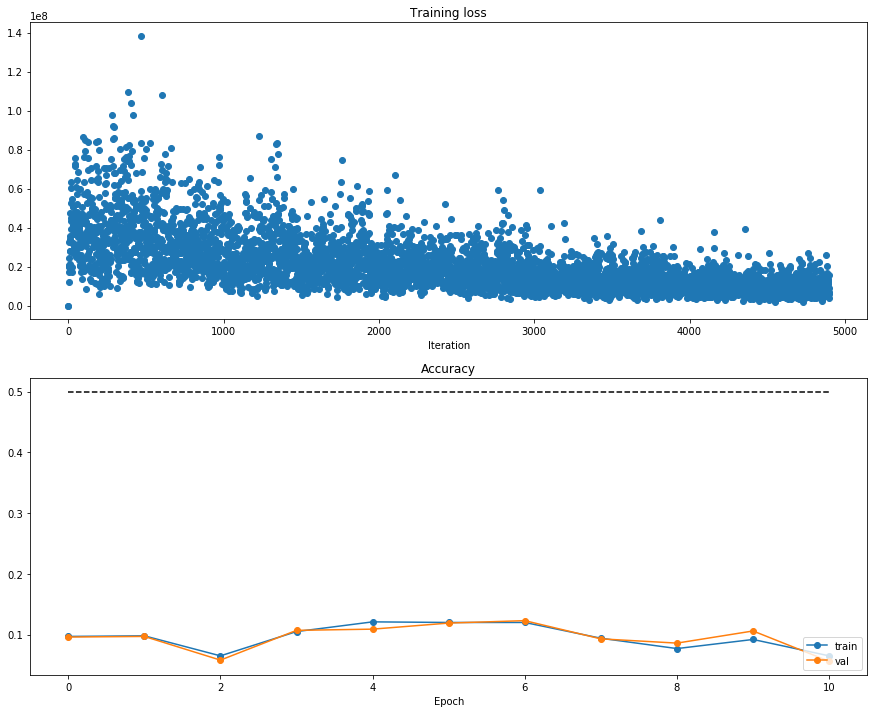

In [13]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [12]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.00e+00
W2 relative error: 1.00e+00
W3 relative error: 3.53e-07
b1 relative error: 1.00e+00
b2 relative error: 1.00e+00
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.00e+00
W2 relative error: 1.00e+00
W3 relative error: 1.00e+00
b1 relative error: 1.00e+00
b2 relative error: 1.00e+00
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

In [ ]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-4
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

In [ ]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-3
weight_scale = 1e-5
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
[FILL THIS IN]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [ ]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

In [ ]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [ ]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())